## Gesture Recognition

### Problem statement

Need to develop a network which will recognise the hand gestures and perform some action depending on the gesture
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

### Steps to build the model

- Data Processing
- Building the generator
- Building the model (CNN-RNN stack and Conv3D)

In [1]:
!pip install tensorflow

In [2]:
!pip install opencv-python

In [3]:
# Importing all the required libraries
# ------------------------------------

import os
import cv2
import datetime
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
import tensorflow as tf
from imageio.v2 import imread
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import backend as K
from keras.optimizers import Adam
from skimage.transform import resize
from keras.models import Sequential, Model
from keras import optimizers, models, layers
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Flatten, \
                                    Dense, Dropout, Conv2D, MaxPooling2D, TimeDistributed
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LeakyReLU


# Setting the random seed
# -----------------------
np.random.seed(30)

rn.seed(30)

tf.random.set_seed(30)

In [4]:
# Reading the data file path csv
# ------------------------------

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data//val.csv').readlines())
batch_size = 8

In [5]:
# Loading the training and validation dataset
# -------------------------------------------

curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


We have 663 training sequences and 100 validation sequences we are trying with 20 epochs and with a batch size of 32

### Understanding the data

In [6]:
# Create a seperate data frame of train data for EDA
train_df = pd.read_csv('Project_data/train.csv', header = None)
train_df = train_df[0].str.split(pat = ';',expand = True)
train_df.rename(columns = {0: 'Name', 1: 'Gesture', 2: 'Class'},inplace = True)
print(train_df.describe() )
print(train_df.head())
print(train_df.sample(n=5, random_state=30))

                                            Name          Gesture Class
count                                        663              663   663
unique                                       663               10     5
top     WIN_20180925_17_08_43_Pro_Left_Swipe_new  Right_Swipe_new     1
freq                                           1              103   137
                                       Name         Gesture Class
0  WIN_20180925_17_08_43_Pro_Left_Swipe_new  Left_Swipe_new     0
1  WIN_20180925_17_18_28_Pro_Left_Swipe_new  Left_Swipe_new     0
2  WIN_20180925_17_18_56_Pro_Left_Swipe_new  Left_Swipe_new     0
3  WIN_20180925_17_19_51_Pro_Left_Swipe_new  Left_Swipe_new     0
4  WIN_20180925_17_20_14_Pro_Left_Swipe_new  Left_Swipe_new     0
                                          Name          Gesture Class
152  WIN_20180926_16_54_08_Pro_Right_Swipe_new  Right_Swipe_new     1
314  WIN_20180925_18_02_58_Pro_Thumbs_Down_new  Thumbs_Down_new     3
12    WIN_20180925_17_33_08_Pro_Le

In [7]:
# Custom function to show the images and their augmentation.
# ----------------------------------------------------------
def imageview(class_img, source_path):
    
    # Get all 30 images in the folder
    # -------------------------------
    images = os.listdir(source_path+'/'+ class_img)
    image = imread(source_path+'/'+ class_img +'/'+images[4])
    print('original:',image.shape)
    
    # Resize the image
    # ----------------
    resized_img = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
    print('resized:',resized_img.shape)
    
    # Apply Gaussian Blur on the image
    # --------------------------------
    blur_image = cv2.GaussianBlur(resized_img, (3,3), 3)
    print('blurred:',blur_image.shape)
    
    # Image Edge Detection
    # --------------------
    edge_image = cv2.Canny(blur_image, 75, 150)

    # Get it into shape of 120x120x3 to maintain same shape through out 
    # -----------------------------------------------------------------
    edge_image1 = cv2.cvtColor(edge_image, cv2.COLOR_GRAY2BGR)
    print('edge:',edge_image1.shape)
    
    # Normalize the image
    # -------------------
    norm_img = resized_img/255
    print('normalized:',norm_img.shape)
    
    fig = plt.figure(figsize = (20, 30))
    
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(image)
    
    plt.subplot(152)
    plt.title('Resized')
    plt.imshow(resized_img) 
     
    plt.subplot(153)
    plt.title('Gaussian Blur')
    plt.imshow(blur_image)
    
    plt.subplot(154)
    plt.title('Edges')
    plt.imshow(edge_image1, cmap = 'gray')
    
    plt.subplot(155)
    plt.title('Normalized')
    plt.imshow(norm_img)

    plt.show()

In [8]:
# Considering two images (one with 120x160x3 and another with 360x360x3) each from every class for analysis
# ---------------------------------------------------------------------------------------------------------
class_0_120 = train_df[train_df['Class']=='0'].reset_index()['Name'][4]
class_0_360 = train_df[train_df['Class']=='0'].reset_index()['Name'][4]

class_1_120 = train_df[train_df['Class']=='1'].reset_index()['Name'][4]
class_1_360 = train_df[train_df['Class']=='1'].reset_index()['Name'][4]

class_2_120 = train_df[train_df['Class']=='2'].reset_index()['Name'][4]
class_2_360 = train_df[train_df['Class']=='2'].reset_index()['Name'][4]

class_3_120 = train_df[train_df['Class']=='3'].reset_index()['Name'][4]
class_3_360 = train_df[train_df['Class']=='3'].reset_index()['Name'][4]

class_4_120 = train_df[train_df['Class']=='4'].reset_index()['Name'][4]
class_4_360 = train_df[train_df['Class']=='4'].reset_index()['Name'][4]

Sample Image for Swipe Left:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


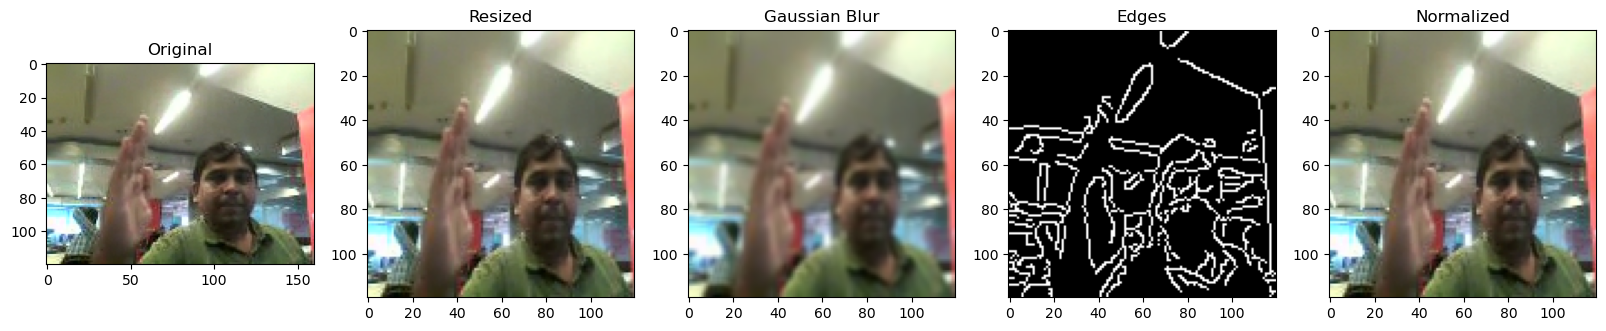

original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


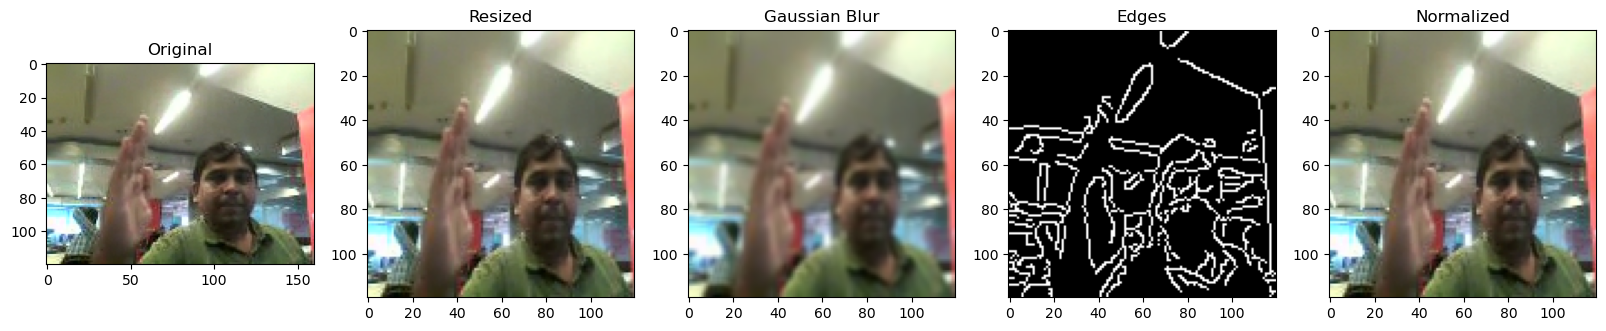

Sample Image for Swipe Right:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


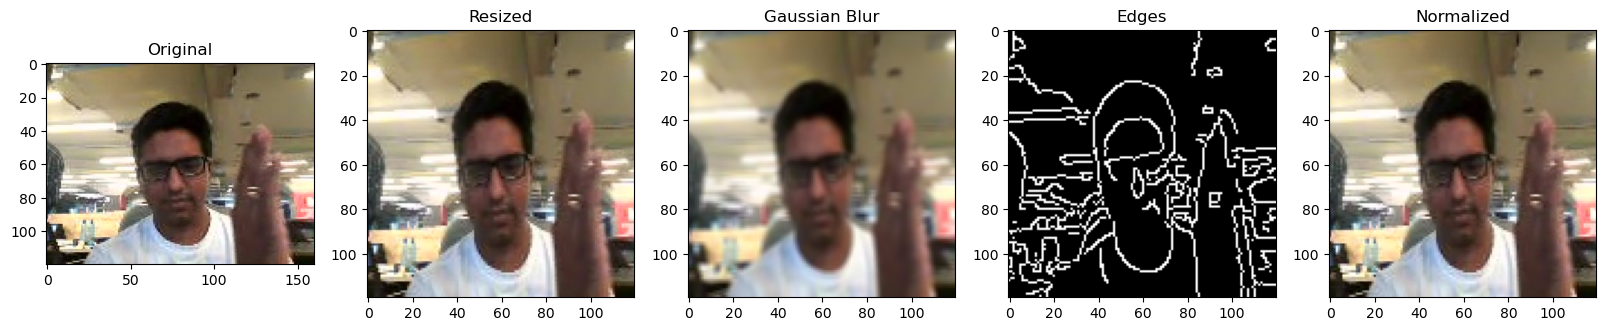

original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


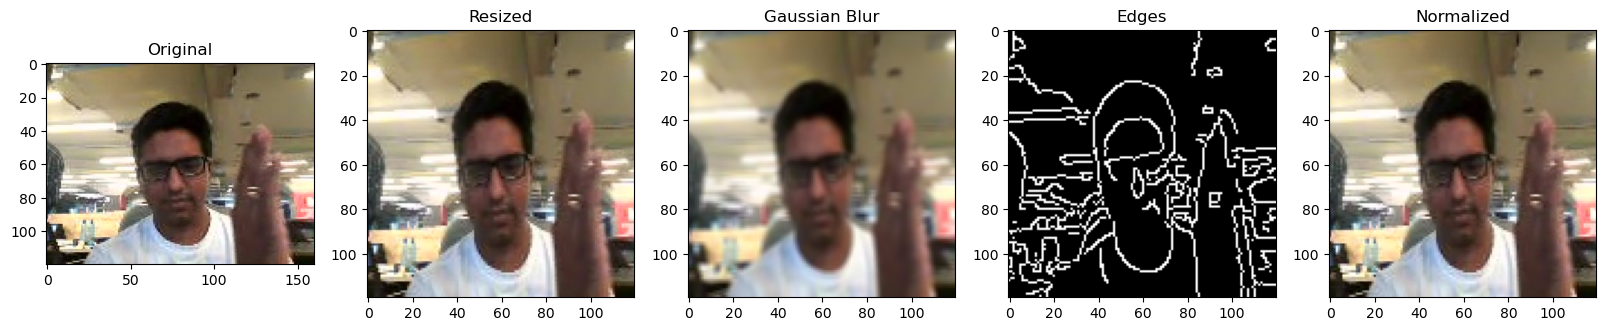

Sample Image for Stop:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


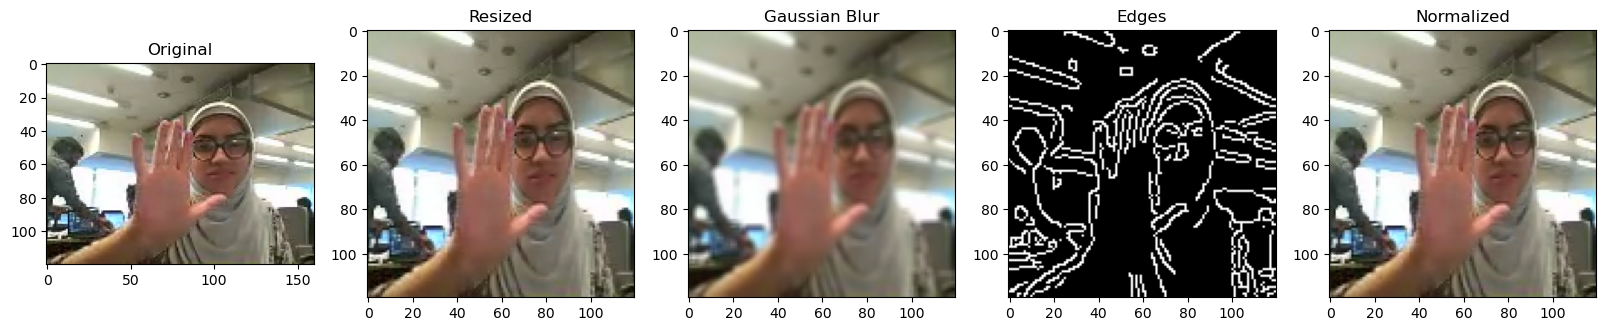

original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


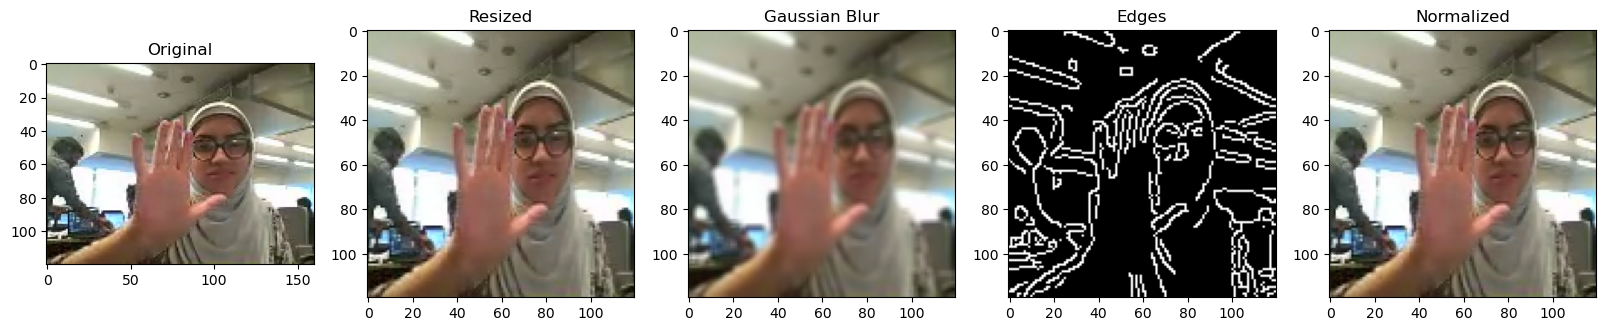

Sample Image for Volume Down:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


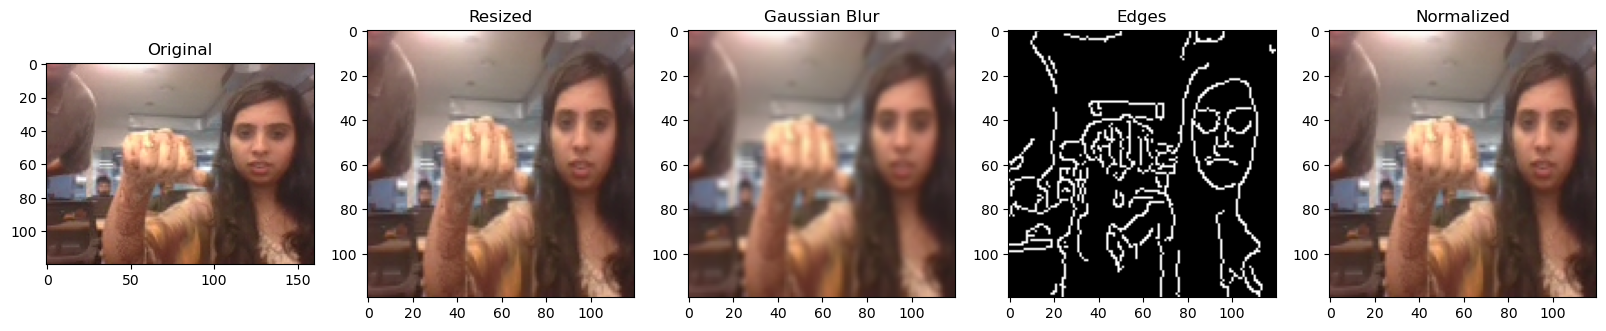

original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


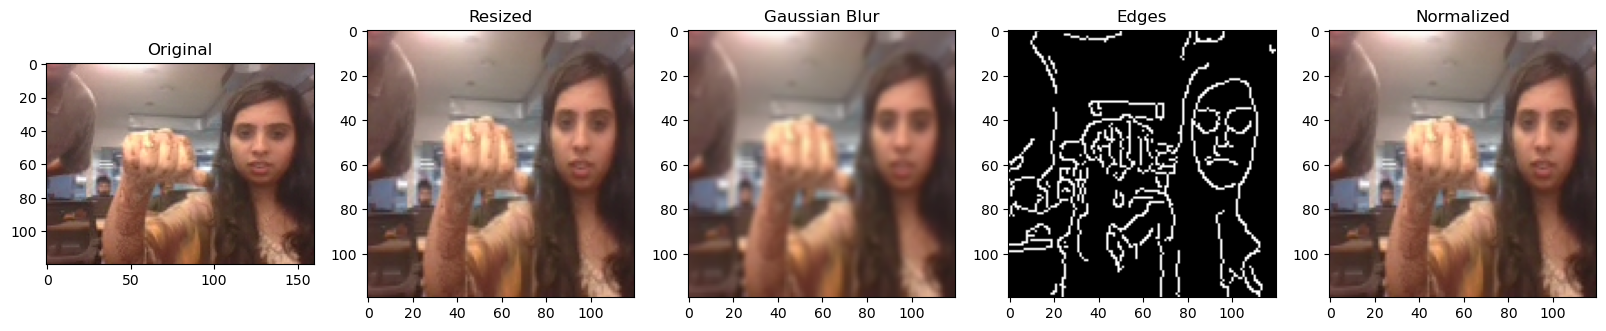

Sample Image for Volume Up:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


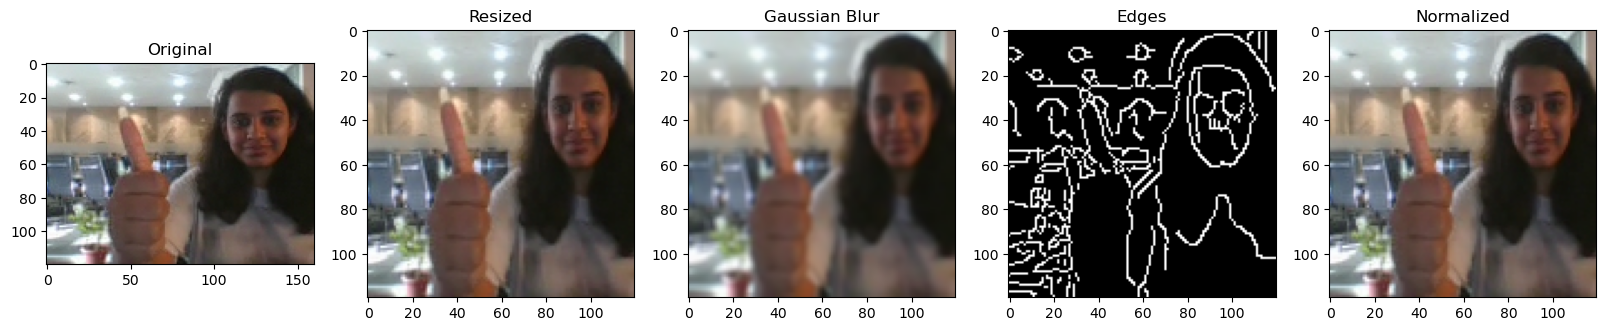

original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


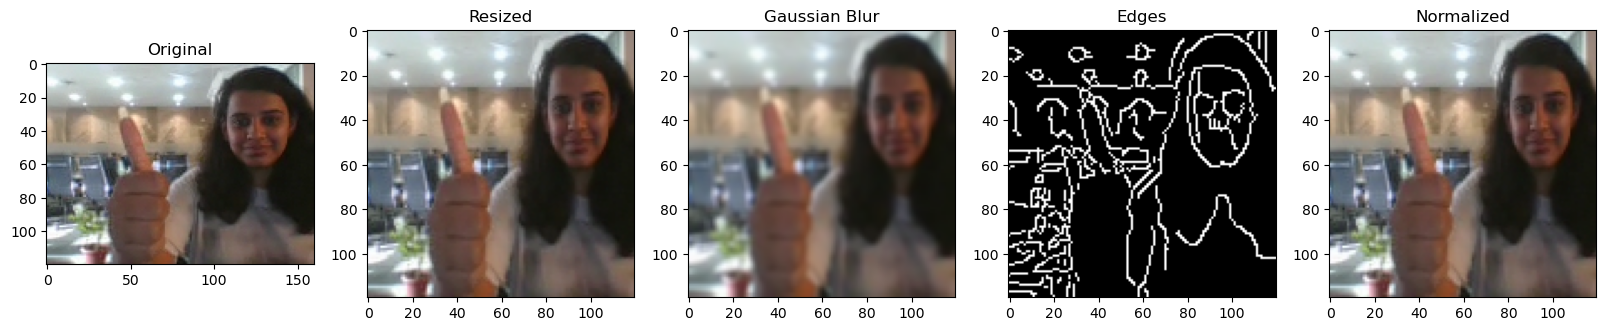

In [9]:
# View the images with their augmented outputs

print('Sample Image for Swipe Left:')
imageview(class_0_120, train_path)
imageview(class_0_360, train_path)

print('Sample Image for Swipe Right:')
imageview(class_1_120, train_path)
imageview(class_1_360, train_path)

print('Sample Image for Stop:')
imageview(class_2_120, train_path)
imageview(class_2_360, train_path)

print('Sample Image for Volume Down:')
imageview(class_3_120, train_path)
imageview(class_3_360, train_path)

print('Sample Image for Volume Up:')
imageview(class_4_120, train_path)
imageview(class_4_360, train_path)

### Generator

In [10]:
# =============================================
""" Data generator class for loading images """
# =============================================
class Generator:
    def __init__(
        self,
        batch_size:int,
        num_classes:int,
        img_idx:list,
        target_size:tuple,
    ):
        self.batch_size = batch_size
        self.img_idx = img_idx
        self.num_classes=num_classes
        self.target_size=target_size

    # Generator function
    # ------------------
    def generator(
        self,
        source_path:str,
        folder_list:str
    ):
        """
        A generator function to yield batches of image data and labels.
    
        Parameters:
        - source_path: The path to the image source directory.
        - folder_list: List of folders containing images, each folder path should be suffixed with ';label'.
        - batch_size: The number of samples per batch.
        - img_idx: List of image indices to use for each video.
        - target_size: Tuple (y, z) for resizing images to the desired dimensions.
    
        Yields:
        - batch_data: Array of shape (batch_size, x, y, z, 3) containing the image data.
        - batch_labels: Array of shape (batch_size, 5) containing the one-hot encoded labels.
        """
        while True:
            t = np.random.permutation(folder_list)
            
            # Calculating the number of batches
            # ---------------------------------
            num_batches = len(folder_list) // self.batch_size  
            for batch in range(num_batches): # Iterate over the number of batches
                
                # Defining the batch data for the image
                # -------------------------------------
                batch_data = np.zeros(
                    (
                        self.batch_size, 
                        len(self.img_idx),
                        *target_size,
                        3
                    )
                )
                
                # Defining the batch labels for the image
                # -------------------------------------
                batch_labels = np.zeros(
                    (
                        self.batch_size,
                        self.num_classes
                    )
                )
                for folder in range(self.batch_size): # Iterate over the batch size
                    
                    # Creating the image path
                    # -----------------------
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                    
                    for idx, item in enumerate(self.img_idx): # Iterate over the images
                        
                        # Reading the image
                        # ----------------
                        image = imread(
                            source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                        ).astype(np.float32)
                        image= resize(image,[120,120]) # Resizing the image

                        # Normalize the image
                        # -------------------
                        batch_data[folder,idx,:,:,0] = (image[:, : , 0] - np.percentile(image[:, : , 0],5))/ (np.percentile(image[:, : , 0],95) - np.percentile(image[:, : , 0],5))
                        batch_data[folder,idx,:,:,1] = (image[:, : , 1] - np.percentile(image[:, : , 1],5))/ (np.percentile(image[:, : , 1],95) - np.percentile(image[:, : , 1],5))
                        batch_data[folder,idx,:,:,2] = (image[:, : , 2] - np.percentile(image[:, : , 2],5))/ (np.percentile(image[:, : , 2],95) - np.percentile(image[:, : , 2],5))
                        
                        
                    # Creating the batch_labels
                    # -------------------------
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                        
                yield batch_data, batch_labels
        
            # Handle remaining data points
            if len(t) % self.batch_size != 0:
                remaining = len(t) % self.batch_size
                batch_data = np.zeros((remaining, len(self.img_idx), *self.target_size, 3))
                batch_labels = np.zeros((remaining, self.num_classes))

                for folder in range(remaining):
                    # Creating the image path
                    # -----------------------
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])

                    for idx, item in enumerate(self.img_idx):
                        # Reading the image
                        # ----------------
                        image = imread(
                            source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                        ).astype(np.float32)
                        
                        image= resize(image,[120,120])
                        batch_data[folder,idx,:,:,0] = (image[:, : , 0] - np.percentile(image[:, : , 0],5))/ (np.percentile(image[:, : , 0],95) - np.percentile(image[:, : , 0],5))
                        batch_data[folder,idx,:,:,1] = (image[:, : , 1] - np.percentile(image[:, : , 1],5))/ (np.percentile(image[:, : , 1],95) - np.percentile(image[:, : , 1],5))
                        batch_data[folder,idx,:,:,2] = (image[:, : , 2] - np.percentile(image[:, : , 2],5))/ (np.percentile(image[:, : , 2],95) - np.percentile(image[:, : , 2],5))
                        
                        
                    # Creating the batch_labels
                    # -------------------------
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

                yield batch_data, batch_labels          
                        

In [11]:
"""
While analysing the image dataset it seems that first couple of frames and the last couple of frames
don't have any significant gestures indication so we define out image index to avoid the first and last 5 data
We need to try with different values
"""

# Defining the parameters
# -----------------------
img_idx = [x for x in range(0,30)]
target_size=(120,120)
num_classes=5

# Initialising the generator class
# --------------------------------
data_generator = Generator(
    batch_size=batch_size,
    num_classes=num_classes, # As we have 5 different gestures
    img_idx=img_idx,
    target_size=target_size # Need to try out with different values
)

# Calling the data generator for training dataset
# -----------------------------------------------
train_generator = data_generator.generator(
    source_path=train_path,
    folder_list=train_doc,
)

# Calling the data generator for validation dataset
# -----------------------------------------------
val_generator = data_generator.generator(
    source_path=val_path,
    folder_list=val_doc
)

In [12]:
# Defining the input shape for the model
# --------------------------------------

num_frames = len(img_idx)  # Number of frames used in the sequence
height, width = target_size
channels = 3  # RGB images

input_shape = (num_frames, height, width, channels)

### Model Building

In [13]:
!pip install torch

## Model 1

In [14]:
# Defining the model architecture
# -------------------------------
model1 = Sequential([
    Conv3D(16, (3, 3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(32, (3, 3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),
    
    Conv3D(64, (3, 3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(1, 1, 1)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compiling the model
# -------------------
model1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [16]:
# Analysing the model summary
# --------------------------
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 28, 118, 118,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 118, 118,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 14, 59, 59, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 57, 57, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 57, 57, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 6, 28, 28, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 26, 26, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 26, 26, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 26, 26, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    22,151,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,222,917 (84.77 MB)

 Trainable params: 22,222,693 (84.77 MB)

 Non-trainable params: 224 (896.00 B)

In [17]:
# Current date and time, should be defined earlier in your code
curr_dt_time = datetime.datetime.now()

model_name = 'model1_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.keras'
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                             save_weights_only=False, mode='auto', save_freq='epoch')

# Reduce learning rate when a metric has stopped improving
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, 
                       mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks_list = [checkpoint, LR]

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3005 - loss: 16.3313
Epoch 1: saving model to model1_init_2024-07-3109_03_28.753267/model-00001-11.26408-0.30166-4.45297-0.26000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - categorical_accuracy: 0.3005 - loss: 16.2710 - val_categorical_accuracy: 0.2600 - val_loss: 4.4530 - learning_rate: 0.0010
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2822 - loss: 3.8843
Epoch 2: saving model to model1_init_2024-07-3109_03_28.753267/model-00002-3.82488-0.28356-9.71587-0.25000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - categorical_accuracy: 0.2822 - loss: 3.8835 - val_categorical_accuracy: 0.2500 - val_loss: 9.7159 - learning_rate: 0.0010
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2470 - loss: 3.4787
Epoch 3: saving model to model1_init_2024-07-3109_03_28.753267/model-00003-3.84151-0.25641-24.96285-0.17000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - ca

From this the model seems to be overfitting to the training dataset, and the validation accuracy is reducing we need to try the following to see if the model is performing better

- Adding more normalisation
- Increase the pooling
- Increase the kernal size
- Try to add some data regularization

## Model 2

In [20]:
# Defining the model architecture
# -------------------------------
model2 = Sequential([
    Conv3D(16, (3, 3, 3), input_shape=input_shape, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling3D(pool_size=(3, 3, 3)),
    
    Conv3D(32, (3, 3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling3D(pool_size=(3, 3, 3)),
    Dropout(0.25),
    
    Conv3D(64, (3, 3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling3D(pool_size=(3, 3, 3)),

    Flatten(),
    Dense(500, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [22]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 10, 40, 40, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 10, 40, 40, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 40, 40, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10, 40, 40, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 3, 13, 13, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 13, 13, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 3, 13, 13, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 13, 13, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 13, 13, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 1, 4, 4, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       512,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 585,981 (2.24 MB)

 Trainable params: 585,757 (2.23 MB)

 Non-trainable params: 224 (896.00 B)

In [23]:
curr_dt_time = datetime.datetime.now()

model_name = 'model2_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.keras'
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                             save_weights_only=False, mode='auto', save_freq='epoch')

# Reduce learning rate when a metric has stopped improving
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, 
                       mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks_list = [checkpoint, LR]

In [24]:
model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2385 - loss: 4.4126
Epoch 1: saving model to model2_init_2024-07-3109_47_56.164614/model-00001-3.00016-0.27451-1.99769-0.20000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - categorical_accuracy: 0.2389 - loss: 4.3958 - val_categorical_accuracy: 0.2000 - val_loss: 1.9977 - learning_rate: 0.0010
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3903 - loss: 1.4193
Epoch 2: saving model to model2_init_2024-07-3109_47_56.164614/model-00002-1.39652-0.41176-2.62919-0.17000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - categorical_accuracy: 0.3905 - loss: 1.4190 - val_categorical_accuracy: 0.1700 - val_loss: 2.6292 - learning_rate: 0.0010
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3935 - loss: 1.3561
Epoch 3: saving model to model2_init_2024-07-3109_47_56.164614/model-00003-1.33344-0.40875-2.74738-0.21000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - catego

This model also seems to be overfitting to the train data, Now let's try bby adjusting the batch size and the input shape

In [25]:
num_frames = len(img_idx)  # Number of frames used in the sequence
height, width = target_size
channels = 3  # RGB images

input_shape = (num_frames, height, width, channels)

In [27]:
# 16,32,64 kernels in 3 consecutive conv3D layers
model6 = Sequential([
    Conv3D(16, (3,3,3), input_shape=(30, 120, 120, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling3D(pool_size=(3,3,3)),

    Conv3D(32, (3,3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling3D(pool_size=(3,3,3)),
    Dropout(0.25),

    Conv3D(64, (3,3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling3D(pool_size=(2,2,2)),  

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])
# # 1st Layer Group
# model6.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(30,120,120,3),padding='same'))
# model6.add(BatchNormalization())
# model6.add(Activation('relu'))
# model6.add(MaxPooling3D(pool_size=(3,3,3)))
# # 2nd Layer Group
# model6.add(Conv3D(32, kernel_size=(3,3,3),padding='same'))
# model6.add(BatchNormalization())
# model6.add(Activation('relu'))
# model6.add(MaxPooling3D(pool_size=(3,3,3)))
# model6.add(layers.Dropout(0.25))
# # 3rd Layer Group
# model6.add(Conv3D(64, kernel_size=(3,3,3),padding='same'))
# model6.add(BatchNormalization())
# model6.add(Activation('relu'))
# model6.add(MaxPooling3D(pool_size=(2,2,2)))

# # FC layer group
# model6.add(Flatten())
# model6.add(Dense(256, activation='relu'))
# model6.add(layers.Dropout(0.5))
# # Softmax Layer
# model6.add(Dense(5, activation='softmax'))

In [28]:
model6.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [29]:
model6.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 30, 120, 120,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 120, 120,   │            64 │
│ (BatchNormalization)            │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 30, 120, 120,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 10, 40, 40, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 10, 40, 40, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 40, 40, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 10, 40, 40, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 3, 13, 13, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 13, 13, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 3, 13, 13, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 13, 13, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3, 13, 13, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 1, 6, 6, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 662,341 (2.53 MB)

 Trainable params: 662,117 (2.53 MB)

 Non-trainable params: 224 (896.00 B)

In [30]:
curr_dt_time = datetime.datetime.now()

model_name = 'model6_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.keras'
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, 
                             save_weights_only=False, mode='auto', save_freq='epoch')

# Reduce learning rate when a metric has stopped improving
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, 
                       mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks_list = [checkpoint, LR]

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2293 - loss: 4.0362
Epoch 1: saving model to model6_init_2024-07-3110_37_32.553939/model-00001-2.70491-0.26848-1.64502-0.29000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - categorical_accuracy: 0.2297 - loss: 4.0203 - val_categorical_accuracy: 0.2900 - val_loss: 1.6450 - learning_rate: 0.0010
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4037 - loss: 1.3863
Epoch 2: saving model to model6_init_2024-07-3110_37_32.553939/model-00002-1.28944-0.45400-2.24414-0.19000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 229s 3s/step - categorical_accuracy: 0.4043 - loss: 1.3852 - val_categorical_accuracy: 0.1900 - val_loss: 2.2441 - learning_rate: 0.0010
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5459 - loss: 1.1218
Epoch 3: saving model to model6_init_2024-07-3110_37_32.553939/model-00003-1.11368-0.54299-2.03492-0.21000.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - catego

This mode is seems the best model it have 93.6 accuracy in test data and 92.0 accuracy at validation data

## Model 7  Using GRU

### RNN + CNN Stack architecure

In [ ]:
model7 = Sequential([
    TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(30,120,120,3))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((3,3))),

    TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((3,3))),

    TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((3,3))),

    TimeDistributed(Flatten()),
    GRU(64),
    Dropout(0.5),
    Dense(5, activation='softmax')
])